In [26]:
from datetime import datetime
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

In [27]:
tp = pd.read_csv("Result_Wait-4.csv", iterator=True, chunksize=1000)
df = pd.concat(tp, ignore_index=True)

df['time'] = df['time'].apply(lambda x: datetime.strptime(x, '%d-%b-%Y %H:%M:%S'))
df['date'] = df['time'].apply(lambda x: x.strftime("%Y/%m/%d"))
# df['detail_time'] = df['time'].apply(lambda x: x.strftime("%H:%M:%S"))
df['detail_time'] = df['time'].apply(lambda x: x.time())
df['weekday'] = df['time'].apply(lambda x: x.strftime('%A'))

In [28]:
df.head(5)

,posture,x,y,speed,week,ind,traitement,breed,time,temperature,date,detail_time,weekday
0,3,3.861676,92.686224,0.000000,5,200002,1,0,2020-08-19 08:30:00,29.0,2020/08/19,08:30:00,Wednesday
1,3,5.414635,87.580417,5.336754,5,200002,1,0,2020-08-19 08:30:30,29.0,2020/08/19,08:30:30,Wednesday
2,3,7.015623,99.617082,12.142671,5,200002,1,0,2020-08-19 08:31:00,29.0,2020/08/19,08:31:00,Wednesday
3,4,93.993134,155.479983,103.371907,5,200002,1,0,2020-08-19 08:31:30,29.0,2020/08/19,08:31:30,Wednesday
4,4,131.654742,82.356483,82.252313,5,200002,1,0,2020-08-19 08:32:00,29.5,2020/08/19,08:32:00,Wednesday


In [29]:
pd.get_dummies(df['posture'])

,1,2,3,4,5
0,0,0,1,0,0
1,0,0,1,0,0
2,0,0,1,0,0
3,0,0,0,1,0
4,0,0,0,1,0
...,...,...,...,...,...
537345,0,0,0,1,0
537346,0,0,0,1,0
537347,0,0,0,1,0
537348,0,0,0,1,0


In [30]:
timestamp = df['time'].unique()
pid_list = df['ind'].unique()

predict = ['posture']
feature = ['x', 'y', 'speed', 'traitement', 'breed', 'temperature']
feature_df = ['ind', 'posture', 'x', 'y', 'speed', 'traitement', 'breed', 'temperature', 'time']
agg_time = pd.date_range(start=df['time'].min(), end=df['time'].max(), freq="30min")

# data
label = None # np.empty((len(timestamp), len(pid_list), 5))
data = None #np.empty((len(timestamp), len(pid_list), len(feature)))
adj = np.zeros((len(agg_time), len(pid_list), len(pid_list)))
agg_df = None
agg_adj = None

for p_idx, _pid in enumerate(pid_list):
       filter_B = df['ind'] == _pid
       select_pig = df[ filter_B ].set_index('time').resample("30min").ffill()
       select_pig['time'] = select_pig.index
       select_pig.index = range(len(select_pig))
       row = select_pig[feature].to_numpy() #.ravel()

       # label
       y_row = pd.get_dummies(select_pig['posture'])
       # y_row[np.isnan(y_row)] = 1
       
       row = np.expand_dims(row, axis=1)
       # print(row.shape)
       y_row = np.expand_dims(y_row, axis=1)

       if row.shape[0] == 0:
              data[:][p_idx] =  np.empty(len(feature))
              y_truth[t_idx][p_idx] = np.nan
              print('row nan')
       else:
              if data is None:
                     data = row
                     y_truth = y_row
                     agg_df = select_pig[feature_df]
              else:
                     data = np.concatenate((data, row), axis=1)
                     y_truth = np.concatenate((y_truth, y_row), axis=1)
                     agg_df = pd.concat([agg_df, select_pig[feature_df]])
       for p_idx_2, _pid_2 in enumerate(pid_list):
              filter_C = df['ind'] == _pid_2
              select_pig_2 = df[ filter_C ].set_index('time').resample("30min").ffill()

              first_x = select_pig['x'].values
              first_y = select_pig['y'].values

              sec_x = select_pig_2['x'].values
              sec_y = select_pig_2['y'].values

              dist = (first_x - sec_x) ** 2 + (first_y - sec_y) ** 2
              dist = dist ** 0.5
              adj[:, p_idx, p_idx_2] = dist

agg_df.index = range(len(agg_df))
print(data.shape, y_truth.shape, adj.shape)

(4579, 10, 6) (4579, 10, 5) (4579, 10, 10)


In [31]:
num_row = 4579

adj_df = agg_df

for p_id in pid_list:
    adj_df[p_id] = 0

for i, p_id in enumerate(pid_list):
    link = adj[:, i]
    linked = link > 70
    # print(linked.shape, adj_df.loc[num_row * i: num_row *(i+1)-1, pid_list].shape)
    adj_df.loc[num_row * i : num_row * (i+1)-1, pid_list] = linked
print(adj_df.head(5))

        ind  posture          x           y     speed  traitement  breed  \
0  200002.0      4.0  11.978012   70.496874  0.000000         1.0    0.0   
1  200002.0      3.0  88.959491  134.882619  9.047293         1.0    0.0   
2  200002.0      5.0  80.451316  125.843261  3.072955         1.0    0.0   
3  200002.0      4.0   9.492997   69.291319  1.218399         1.0    0.0   
4  200002.0      5.0  42.256037  134.660285  9.000454         1.0    0.0   

   temperature                time 200002 200004 200011 200013 200014 204926  \
0         29.0 2020-06-24 08:30:00  False   True   True   True  False   True   
1         29.0 2020-06-24 09:00:00  False  False   True   True  False   True   
2         29.0 2020-06-24 09:30:00  False   True   True   True   True   True   
3         29.0 2020-06-24 10:00:00  False  False   True   True  False  False   
4         29.0 2020-06-24 10:30:00  False   True   True   True   True   True   

  204927 204938 204945 204946  
0  False   True  False   True 

C:\Users\ctsu\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.


In [32]:
def drop_nan(df):
    print('nan:', df[df['ind'].isna()])
    df = df.dropna()
    df['ind'] = df['ind'].astype(int).astype(str)
    print(df.shape)
    return df

agg_df = drop_nan(agg_df)
adj_df = drop_nan(adj_df)

nan:        ind  posture   x   y  speed  traitement  breed  temperature  \
18316  NaN      NaN NaN NaN    NaN         NaN    NaN          NaN   

                     time 200002 200004 200011 200013 200014 204926 204927  \
18316 2020-06-24 08:30:00  False  False  False  False  False  False  False   

      204938 204945 204946  
18316  False  False  False  


C:\Users\ctsu\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


(45789, 19)
nan:        ind  posture   x   y  speed  traitement  breed  temperature  \
18316  NaN      NaN NaN NaN    NaN         NaN    NaN          NaN   

                     time 200002 200004 200011 200013 200014 204926 204927  \
18316 2020-06-24 08:30:00  False  False  False  False  False  False  False   

      204938 204945 204946  
18316  False  False  False  
(45789, 19)


C:\Users\ctsu\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [33]:
agg_df.head(5)

,ind,posture,x,y,speed,traitement,breed,temperature,time,200002,200004,200011,200013,200014,204926,204927,204938,204945,204946
0,200002,4.0,11.978012,70.496874,0.000000,1.0,0.0,29.0,2020-06-24 08:30:00,False,True,True,True,False,True,False,True,False,True
1,200002,3.0,88.959491,134.882619,9.047293,1.0,0.0,29.0,2020-06-24 09:00:00,False,False,True,True,False,True,True,True,True,True
2,200002,5.0,80.451316,125.843261,3.072955,1.0,0.0,29.0,2020-06-24 09:30:00,False,True,True,True,True,True,True,True,True,True
3,200002,4.0,9.492997,69.291319,1.218399,1.0,0.0,29.0,2020-06-24 10:00:00,False,False,True,True,False,False,True,True,False,True
4,200002,5.0,42.256037,134.660285,9.000454,1.0,0.0,29.0,2020-06-24 10:30:00,False,True,True,True,True,True,True,True,True,True


In [34]:
df = agg_df

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45789 entries, 0 to 45789
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   ind          45789 non-null  object        
 1   posture      45789 non-null  float64       
 2   x            45789 non-null  float64       
 3   y            45789 non-null  float64       
 4   speed        45789 non-null  float64       
 5   traitement   45789 non-null  float64       
 6   breed        45789 non-null  float64       
 7   temperature  45789 non-null  float64       
 8   time         45789 non-null  datetime64[ns]
 9   200002       45789 non-null  object        
 10  200004       45789 non-null  object        
 11  200011       45789 non-null  object        
 12  200013       45789 non-null  object        
 13  200014       45789 non-null  object        
 14  204926       45789 non-null  object        
 15  204927       45789 non-null  object        
 16  2049

In [36]:
# 確定特徵和目標變量
#X = df[['x', 'y', 'speed', 'traitement', 'breed', 'temperature', '200002', '200004', '200011', '200013', '200014', '204926', '204927', '204938', '204945', '204946']]
#y = df['posture']

In [37]:
columns_to_convert = [200002, 200004, 200011, 200013, 200014, 204926, 204927, 204938, 204945, 204946]

for column in columns_to_convert:
    df[column] = df[column].astype(int)

In [38]:
df

,ind,posture,x,y,speed,traitement,breed,temperature,time,200002,200004,200011,200013,200014,204926,204927,204938,204945,204946
0,200002,4.0,11.978012,70.496874,0.000000,1.0,0.0,29.0,2020-06-24 08:30:00,0,1,1,1,0,1,0,1,0,1
1,200002,3.0,88.959491,134.882619,9.047293,1.0,0.0,29.0,2020-06-24 09:00:00,0,0,1,1,0,1,1,1,1,1
2,200002,5.0,80.451316,125.843261,3.072955,1.0,0.0,29.0,2020-06-24 09:30:00,0,1,1,1,1,1,1,1,1,1
3,200002,4.0,9.492997,69.291319,1.218399,1.0,0.0,29.0,2020-06-24 10:00:00,0,0,1,1,0,0,1,1,0,1
4,200002,5.0,42.256037,134.660285,9.000454,1.0,0.0,29.0,2020-06-24 10:30:00,0,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45785,204946,5.0,126.220773,16.877291,0.481381,0.0,1.0,28.0,2020-09-27 15:30:00,1,0,1,1,1,1,1,0,1,0
45786,204946,5.0,123.087031,5.944065,1.829531,0.0,1.0,28.0,2020-09-27 16:00:00,0,0,1,1,1,0,1,0,1,0
45787,204946,5.0,98.695865,21.413136,5.450935,0.0,1.0,28.0,2020-09-27 16:30:00,0,0,1,0,1,0,0,1,1,0
45788,204946,5.0,102.857665,36.064586,1.938851,0.0,1.0,28.0,2020-09-27 17:00:00,0,0,1,0,1,0,0,1,0,0


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45789 entries, 0 to 45789
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   ind          45789 non-null  object        
 1   posture      45789 non-null  float64       
 2   x            45789 non-null  float64       
 3   y            45789 non-null  float64       
 4   speed        45789 non-null  float64       
 5   traitement   45789 non-null  float64       
 6   breed        45789 non-null  float64       
 7   temperature  45789 non-null  float64       
 8   time         45789 non-null  datetime64[ns]
 9   200002       45789 non-null  int32         
 10  200004       45789 non-null  int32         
 11  200011       45789 non-null  int32         
 12  200013       45789 non-null  int32         
 13  200014       45789 non-null  int32         
 14  204926       45789 non-null  int32         
 15  204927       45789 non-null  int32         
 16  2049

In [40]:
# 確定特徵和目標變量
X = df[['x', 'y', 'speed', 'traitement', 'breed', 'temperature', 200002, 200004, 200011, 200013, 200014, 204926, 204927, 204938, 204945, 204946]]
y = df['posture']

In [41]:
from sklearn.preprocessing import LabelEncoder

# 將字串標籤轉換為整數
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [42]:
# 資料拆分成training set, testing set和validation set
# 使用 y_encoded 作為目標變數
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [43]:
# 根据最佳参数创建 RF 分类器
#best_params = {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}
#rf_model = RandomForestClassifier(**best_params)

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200, 500, 1000],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

# 建立Random Forest模型
rf_model = RandomForestClassifier()

# 创建网格搜索对象
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy')

# 在训练数据上进行网格搜索
grid_search.fit(X_train, y_train)

# 输出最佳参数组合和最佳得分
print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy found: ", grid_search.best_score_)

In [19]:
# 建立Random Forest模型
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

In [20]:
import warnings

# 忽略特定类型的警告
warnings.filterwarnings("ignore", category=FutureWarning)

In [21]:
# 訓練模型
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [22]:
# 預測
y_pred = rf_model.predict(X_val)

In [23]:
# 評估模型
accuracy = accuracy_score(y_val, y_pred)
print(f'Validation Set Accuracy: {accuracy}')
# 最後，使用測試集進行最終評估
y_test_pred = rf_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Set Accuracy: {test_accuracy}')
print(classification_report(y_test, y_test_pred))

Validation Set Accuracy: 0.905503785672685
Test Set Accuracy: 0.9093026641432523
              precision    recall  f1-score   support

           0       0.92      0.79      0.85       720
           1       0.92      0.95      0.93      2240
           2       1.00      0.91      0.95       485
           3       0.94      0.93      0.94      2197
           4       0.81      0.87      0.84      1227

    accuracy                           0.91      6869
   macro avg       0.92      0.89      0.90      6869
weighted avg       0.91      0.91      0.91      6869



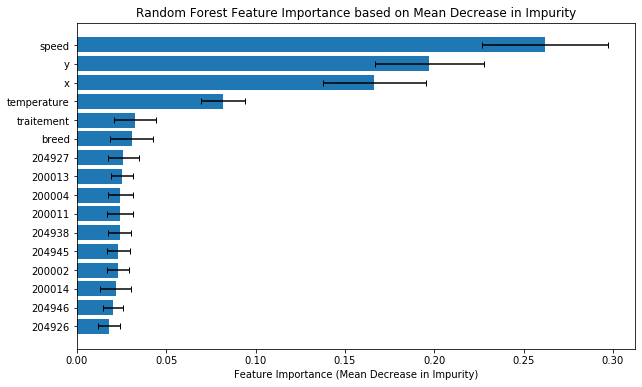

In [24]:
importances = rf_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)

# 獲取特徵名稱
feature_names = X.columns

# 建立一個包含特徵名稱、其對應重要性和標準差的 DataFrame
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances, 'Std': std})

# 依照重要性降序排列
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)

# 將特徵名稱轉換為字符串
feature_names = feature_importance_df['Feature'].astype(str)

# 繪製條形圖
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importance_df['Importance'], xerr=feature_importance_df['Std'], capsize=3)
plt.xlabel('Feature Importance (Mean Decrease in Impurity)')
plt.title('Random Forest Feature Importance based on Mean Decrease in Impurity')
plt.savefig('RF_FeatureImportance_2.png')
plt.show()

In [25]:
params = rf_model.get_params()
print(params)

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
